In [3]:
pip install -U albumentations

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.ops import MultiScaleRoIAlign, RoIPool
from torch.utils.data import DataLoader
import numpy as np
import os
import subprocess
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
# Download training images
!wget http://images.cocodataset.org/zips/train2017.zip

# Download validation images
!wget http://images.cocodataset.org/zips/val2017.zip

# Download COCO annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-03-16 04:38:54--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.61.97, 52.217.88.156, 3.5.28.63, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.61.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‚Äòtrain2017.zip‚Äô

train2017.zip       100%[===================>]  18.01G   103MB/s    in 3m 45s  

2025-03-16 04:42:40 (81.8 MB/s) - ‚Äòtrain2017.zip‚Äô saved [19336861798/19336861798]

--2025-03-16 04:42:40--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.200.129, 16.182.34.161, 3.5.2.108, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.200.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‚Äòval2017.zip‚Äô

val2017.zip         100%[==================

In [5]:
!unzip -o train2017.zip
!unzip -o val2017.zip
!unzip -o annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/00000019

In [6]:
# Custom Region Proposal Network (RPN)
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

In [7]:
class BoxHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, 1024)  # ‚úÖ Input should be 12544
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)  # ‚úÖ Class logits
        self.bbox_pred = nn.Linear(1024, num_classes * 4)  # ‚úÖ Bounding box regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_logits = self.cls_score(x)  # ‚úÖ Class Scores
        bbox_preds = self.bbox_pred(x)  # ‚úÖ Box Predictions
        return cls_logits, bbox_preds


In [8]:
# Custom Mask Head (Fully Convolutional Layers)
class MaskHead(nn.Module):
    def __init__(self, in_channels, hidden_dim=256, num_classes=91):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(hidden_dim, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x


In [9]:
import torchvision.models.detection.backbone_utils as backbone_utils
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_resnet_backbone():
    backbone = resnet_fpn_backbone("resnet50", weights="DEFAULT")  # ‚úÖ Use ResNet50 with FPN
    return backbone


In [18]:
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = get_resnet_backbone()  # ‚úÖ Use Pretrained ResNet
        self.rpn = RPN(2048, num_anchors=9)
        self.roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)
        self.box_head = BoxHead(7 * 7 * 256, num_classes)  # ‚úÖ Bounding Box Head
        self.mask_head = MaskHead(256, num_classes=num_classes)  # ‚úÖ Mask Head

    def forward(self, images, proposals=None):
        features = self.backbone(images)  # ‚úÖ Extract features

        # ‚úÖ Fix `feature_dict` to correctly handle different backbone outputs
        if isinstance(features, dict):
            feature_dict = features  # ‚úÖ Already a dictionary (FPN case)
        elif isinstance(features, list):
            feature_dict = {str(i): feat for i, feat in enumerate(features)}  # ‚úÖ Convert list to dict
        else:
            feature_dict = {"0": features}  # ‚úÖ Single tensor case (No FPN)

        # ‚úÖ Generate proposals if not provided
        if proposals is None:
            rpn_logits, rpn_bbox = self.rpn(features)
            proposals = rpn_bbox

        # ‚úÖ Fix `image_shapes` format
        image_shapes = [(images.shape[-2], images.shape[-1])] * images.shape[0]

        # ‚úÖ Convert `proposals` into List[Tensor]
        proposals_per_image = []
        batch_size = images.shape[0]

        for i in range(batch_size):
            mask = proposals[:, 0] == i  # ‚úÖ Select proposals for image `i`
            if mask.sum() == 0:  # ‚úÖ Handle empty proposals
                proposals_per_image.append(torch.empty((0, 4), dtype=proposals.dtype, device=proposals.device))
            else:
                proposals_per_image.append(proposals[mask][:, 1:])  # ‚úÖ Remove batch index column

        # ‚úÖ Apply RoI Align
        pooled_regions = self.roi_pool(feature_dict, proposals_per_image, image_shapes)

        # ‚úÖ Ensure `pooled_regions` is not empty
        if pooled_regions.numel() == 0:
            raise ValueError("‚ùå RoIAlign produced empty regions, check proposals input.")

        # ‚úÖ Ensure correct shape before passing to BoxHead
        if pooled_regions.dim() != 4:
            raise ValueError(f"‚ùå Expected 4D tensor (N, C, 7, 7), got {pooled_regions.shape}")

        # ‚úÖ Get feature map size
        C, H, W = pooled_regions.shape[1], pooled_regions.shape[2], pooled_regions.shape[3]
        expected_size = C * H * W  # Should be 256 * 7 * 7 = 12544

        # ‚úÖ Ensure correct reshaping
        if expected_size != 12544:
            raise ValueError(f"‚ùå Feature map has incorrect channels: {C}. Expected 256.")

        flattened_pooled = pooled_regions.view(pooled_regions.size(0), expected_size)

        # ‚úÖ Debugging Print (Optional)
        if batch_idx == 0:  # ‚úÖ Print only for the first batch of each epoch
           print(f"‚úÖ Reshaped pooled_regions: Expected {expected_size}, Got {flattened_pooled.shape[1]}")


        # ‚úÖ Compute Class & Box Predictions
        class_logits, bbox_deltas = self.box_head(flattened_pooled)

        # ‚úÖ Compute Mask Predictions
        masks = self.mask_head(pooled_regions)

        return class_logits, bbox_deltas, masks


In [19]:
import os

train_images_path = "train2017"
annotations_path = "annotations/instances_train2017.json"

# Check if the image directory exists
print("Train Images Exist:", os.path.exists(train_images_path))

# Check if the annotations file exists
print("Annotations Exist:", os.path.exists(annotations_path))


Train Images Exist: True
Annotations Exist: True


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.ops import RoIAlign
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
import json
import time
from PIL import Image
from pycocotools.coco import COCO

# ‚úÖ Set Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# ‚úÖ COCO Dataset Class (Optimized)
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.img_ids = list(self.coco.imgs.keys())[:1000]  # ‚úÖ Use only 20,000 images
        self.transform = transform
        self.img_size = (128, 128)  # ‚úÖ Resize to 128x128 for faster training

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # ‚úÖ Resize image
        image = image.resize(self.img_size, Image.BILINEAR)

        # Get bounding boxes & masks
        boxes, masks, labels = [], [], []

        for ann in anns:
            x, y, w, h = ann['bbox']
            x1, y1, x2, y2 = x, y, x + w, y + h
            boxes.append([x1, y1, x2, y2])

            mask = self.coco.annToMask(ann)
            mask = cv2.resize(mask, self.img_size)  # Resize mask
            masks.append(mask)

            labels.append(ann['category_id'])

        # ‚úÖ Handle Empty Annotations
        if len(boxes) == 0 or len(labels) == 0:
            return self.__getitem__((idx + 1) % len(self.img_ids))  # Skip empty images

        # ‚úÖ Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32).reshape(-1, 4)  # Shape (N, 4)
        masks = torch.tensor(np.array(masks), dtype=torch.uint8).unsqueeze(1)  # Shape (N, 1, H, W)
        labels = torch.tensor(labels, dtype=torch.int64).flatten()  # Shape (N,)

        if self.transform:
            image = self.transform(image)

        return image, boxes, masks, labels

# ‚úÖ Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.RandomHorizontalFlip(p=0.5),  # ‚úÖ Flip images randomly
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # ‚úÖ Improve feature learning
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # ‚úÖ Reduce noise
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ‚úÖ Normalize using ImageNet stats
])

# ‚úÖ Collate Function to Handle Variable-Sized Batches
def collate_fn(batch):
    images, boxes, masks, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    return images, boxes, masks, labels  # Keep boxes/masks/lables as lists

# ‚úÖ Create Dataset & DataLoader (Optimized)
train_dataset = COCODataset("train2017", "annotations/instances_train2017.json", transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# ‚úÖ Check Dataset
print(f"Total images in dataset: {len(train_dataset)}")
for images, boxes, masks, labels in train_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Boxes shape: {boxes[0].shape}")
    print(f"Masks shape: {masks[0].shape}")
    print(f"Labels: {labels[0]}")
    break  # ‚úÖ Stop after first batch check


Using Device: cuda
loading annotations into memory...
Done (t=16.87s)
creating index...
index created!
Total images in dataset: 1000
Batch size: 16
Image shape: torch.Size([3, 128, 128])
Boxes shape: torch.Size([5, 4])
Masks shape: torch.Size([5, 1, 128, 128])
Labels: tensor([72,  1, 72, 62, 62])


In [21]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")


CUDA Available: True
Device: cuda


In [22]:
import time

start = time.time()
data = next(iter(train_loader))  # Load one batch
end = time.time()

print(f"‚è≥ Time to load one batch: {end - start:.4f} seconds")


‚è≥ Time to load one batch: 0.7584 seconds


In [23]:
# Approach 1

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

# ‚úÖ Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ‚úÖ Load Model & Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskRCNN(num_classes=91).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ‚úÖ Loss Functions
loss_fn_cls = nn.CrossEntropyLoss(label_smoothing=0.2)
loss_fn_bbox = nn.SmoothL1Loss()
loss_fn_mask = nn.BCEWithLogitsLoss()

scaler = GradScaler()

# ‚úÖ Training Loop
epochs = 20
accumulate_steps = 4

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    total_loss, correct_preds, total_preds = 0, 0, 0

    for batch_idx, (images, boxes, masks, labels) in enumerate(train_loader):
        images = torch.stack([img.to(device) for img in images])
        boxes = [b.to(device) for b in boxes]
        masks = [m.to(device) for m in masks]
        labels = [l.to(device) for l in labels]

        # ‚úÖ Skip Empty Labels to Prevent Errors
        if len(labels) == 0 or len(boxes) == 0:
            print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
            continue

        # ‚úÖ Normalize & Clamp Bounding Boxes
        for i in range(len(boxes)):
            image_w, image_h = images.shape[3], images.shape[2]
            boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
            boxes[i] = torch.clamp(boxes[i], min=0, max=1)

        num_proposals = min(15, max(len(b) for b in boxes))
        proposals, proposal_labels, proposal_boxes = [], [], []

        for i, (b, l) in enumerate(zip(boxes, labels)):
            if len(b) == 0:
                continue
            b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
            formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
            proposals.append(formatted_boxes[:num_proposals])
            proposal_labels.append(l[:num_proposals])
            proposal_boxes.append(b[:num_proposals])

        if len(proposals) > 0:
            proposals = torch.cat(proposals, dim=0).to(device)
            proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
            proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
        else:
            proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
            proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
            proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

        # ‚úÖ Forward Pass with Mixed Precision
        with autocast():
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

        # ‚úÖ Compute Losses
        loss_cls = loss_fn_cls(class_logits, proposal_labels)
        selected_bbox_deltas = bbox_deltas.view(-1, 91, 4)
        predicted_classes = torch.argmax(class_logits, dim=1)
        selected_bbox_deltas = selected_bbox_deltas[torch.arange(selected_bbox_deltas.size(0)), predicted_classes]
        loss_bbox = loss_fn_bbox(selected_bbox_deltas, proposal_boxes)

        resized_masks = F.interpolate(masks[0].float(), size=mask_logits.shape[-2:], mode="bilinear", align_corners=False)

        # ‚úÖ Ensure masks match mask_logits channels
        if resized_masks.shape[1] == 1 and mask_logits.shape[1] > 1:
            resized_masks = resized_masks.repeat(1, mask_logits.shape[1], 1, 1)
        elif resized_masks.shape[1] > 1 and mask_logits.shape[1] == 1:
            resized_masks = resized_masks[:, :1, :, :]

        # ‚úÖ Ensure batch sizes match
        if resized_masks.shape[0] < mask_logits.shape[0]:
            pad_size = mask_logits.shape[0] - resized_masks.shape[0]
            padding = torch.zeros((pad_size, mask_logits.shape[1], *mask_logits.shape[-2:]), dtype=resized_masks.dtype, device=resized_masks.device)
            resized_masks = torch.cat([resized_masks, padding], dim=0)
        elif resized_masks.shape[0] > mask_logits.shape[0]:
            resized_masks = resized_masks[:mask_logits.shape[0]]

        loss_mask = loss_fn_mask(mask_logits, resized_masks)

        # ‚úÖ Total Loss (Normalized)
        loss = (loss_cls + loss_bbox + loss_mask) / len(images)

        # ‚úÖ Convert NaN Losses to Zero & Skip Unstable Batches
        loss = torch.nan_to_num(loss, nan=0.0, posinf=0.0, neginf=0.0)
        if loss == 0 or torch.isnan(loss) or torch.isinf(loss):
            print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to unstable loss")
            optimizer.zero_grad()
            continue

        # ‚úÖ Gradient Accumulation with Clipping
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        if (batch_idx + 1) % accumulate_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(class_logits, dim=1)
        labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

        # ‚úÖ Track Accuracy
        min_size = min(labels_flat.shape[0], preds.shape[0])
        correct_preds += (preds[:min_size] == labels_flat[:min_size]).sum().item()
        total_preds += min_size

        if batch_idx % 100 == 0:
            print(f"üü¢ Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")

    # ‚úÖ Compute Training Accuracy
    scheduler.step()
    train_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0
    epoch_time = time.time() - start_time

    print(f"‚úÖ Epoch {epoch+1} Done: Loss {total_loss:.4f}, Train Acc: {train_accuracy:.4f}, Time: {epoch_time:.2f}s")

    # ‚úÖ Print Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"üìâ Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
<ipython-input-23-050af90d6a7f>:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-23-050af90d6a7f>:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


‚úÖ Reshaped pooled_regions: Expected 12544, Got 12544
üü¢ Epoch 1, Batch 0/63: Loss 0.3523
‚úÖ Epoch 1 Done: Loss 19.9964, Train Acc: 0.2606, Time: 7.65s
üìâ Learning Rate after Epoch 1: 0.000488
‚úÖ Reshaped pooled_regions: Expected 12544, Got 12544
üü¢ Epoch 2, Batch 0/63: Loss 0.2858
‚ö†Ô∏è Skipping batch 56 due to unstable loss
‚úÖ Epoch 2 Done: Loss 18.5598, Train Acc: 0.2667, Time: 5.51s
üìâ Learning Rate after Epoch 2: 0.000452
‚úÖ Reshaped pooled_regions: Expected 12544, Got 12544
üü¢ Epoch 3, Batch 0/63: Loss 0.2974
‚úÖ Epoch 3 Done: Loss 18.6176, Train Acc: 0.2732, Time: 5.28s
üìâ Learning Rate after Epoch 3: 0.000397
‚úÖ Reshaped pooled_regions: Expected 12544, Got 12544
üü¢ Epoch 4, Batch 0/63: Loss 0.3061
‚ö†Ô∏è Skipping batch 10 due to unstable loss
‚ö†Ô∏è Skipping batch 45 due to unstable loss
‚ö†Ô∏è Skipping batch 61 due to unstable loss
‚úÖ Epoch 4 Done: Loss 16.0730, Train Acc: 0.2763, Time: 5.25s
üìâ Learning Rate after Epoch 4: 0.000327
‚úÖ Reshaped pooled_

In [ ]:
# ‚úÖ Save trained model
# model_save_path = "mask_rcnn_trained.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"‚úÖ Model saved as {model_save_path}")


NameError: name 'torch' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/mask_rcnn_trained.pth"  # Change path if needed
torch.save(model.state_dict(), save_path)

print(f"‚úÖ Model saved to Google Drive at {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
‚úÖ Model saved to Google Drive at /content/drive/MyDrive/mask_rcnn_trained.pth


In [ ]:
import torch

# ‚úÖ Define the new save path
save_path = "/content/drive/MyDrive/mask_rcnn_trained_v2.pth"  # Different name

# ‚úÖ Save the entire model (architecture + weights)
torch.save(model, save_path)

print(f"‚úÖ Full model saved successfully at: {save_path}")


‚úÖ Full model saved successfully at: /content/drive/MyDrive/mask_rcnn_trained_v2.pth


In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from torch.nn.functional import interpolate

# # ‚úÖ Create Dataset & DataLoader (Optimized)
# test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# # ‚úÖ Evaluation Function
# def evaluate_model(model, test_loader, device):
#     model.eval()
#     total_correct, total_samples = 0, 0
#     total_loss = 0.0

#     with torch.no_grad():
#         for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
#             images = torch.stack([img.to(device) for img in images])
#             boxes = [b.to(device) for b in boxes]
#             masks = [m.to(device) for m in masks]
#             labels = [l.to(device) for l in labels]

#             if len(labels) == 0 or len(boxes) == 0:
#                 print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
#                 continue

#             for i in range(len(boxes)):
#                 image_w, image_h = images.shape[3], images.shape[2]
#                 boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
#                 boxes[i] = torch.clamp(boxes[i], min=0, max=1)

#             proposals, proposal_labels, proposal_boxes = [], [], []
#             num_proposals = min(15, max(len(b) for b in boxes))

#             for i, (b, l) in enumerate(zip(boxes, labels)):
#                 if len(b) == 0:
#                     continue
#                 b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
#                 formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
#                 proposals.append(formatted_boxes[:num_proposals])
#                 proposal_labels.append(l[:num_proposals])
#                 proposal_boxes.append(b[:num_proposals])

#             if len(proposals) > 0:
#                 proposals = torch.cat(proposals, dim=0).to(device)
#                 proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
#                 proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
#             else:
#                 proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
#                 proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
#                 proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

#             class_logits, bbox_deltas, mask_logits = model(images, proposals)

#             loss_cls = loss_fn_cls(class_logits, proposal_labels)
#             selected_bbox_deltas = bbox_deltas.view(-1, 91, 4)
#             predicted_classes = torch.argmax(class_logits, dim=1)
#             selected_bbox_deltas = selected_bbox_deltas[torch.arange(selected_bbox_deltas.size(0)), predicted_classes]
#             loss_bbox = loss_fn_bbox(selected_bbox_deltas, proposal_boxes)

#             resized_masks = interpolate(masks[0].float(), size=mask_logits.shape[-2:], mode="bilinear", align_corners=False)

#             if resized_masks.shape[1] == 1 and mask_logits.shape[1] > 1:
#                 resized_masks = resized_masks.repeat(1, mask_logits.shape[1], 1, 1)
#             elif resized_masks.shape[1] > 1 and mask_logits.shape[1] == 1:
#                 resized_masks = resized_masks[:, :1, :, :]

#             loss_mask = loss_fn_mask(mask_logits, resized_masks)
#             loss = (loss_cls + loss_bbox + loss_mask) / len(images)
#             total_loss += loss.item()

#             preds = torch.argmax(class_logits, dim=1)
#             labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

#             min_size = min(labels_flat.shape[0], preds.shape[0])
#             total_correct += (preds[:min_size] == labels_flat[:min_size]).sum().item()
#             total_samples += min_size

#             if batch_idx % 50 == 0:
#                 print(f"üîµ Batch {batch_idx}/{len(test_loader)}: Loss {loss.item():.4f}")

#     accuracy = total_correct / total_samples if total_samples > 0 else 0.0
#     avg_loss = total_loss / len(test_loader)
#     print(f"‚úÖ Evaluation Done: Avg Loss {avg_loss:.4f}, Accuracy {accuracy:.4f}")
#     return avg_loss, accuracy

# # ‚úÖ Run Evaluation
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# avg_loss, accuracy = evaluate_model(model, test_loader, device)

In [ ]:
# updated train code
# Approach 2

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

# ‚úÖ Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Random affine for better robustness
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ‚úÖ Load Model & Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskRCNN(num_classes=91).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)  # AdamW is a good optimizer
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ‚úÖ Loss Functions
loss_fn_cls = nn.CrossEntropyLoss(label_smoothing=0.2)
loss_fn_bbox = nn.SmoothL1Loss()
loss_fn_mask = nn.BCEWithLogitsLoss()

scaler = GradScaler()

# ‚úÖ Training Loop
epochs = 100
accumulate_steps = 4

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    total_loss, correct_preds, total_preds = 0, 0, 0

    for batch_idx, (images, boxes, masks, labels) in enumerate(train_loader):
        images = torch.stack([img.to(device) for img in images])
        boxes = [b.to(device) for b in boxes]
        masks = [m.to(device) for m in masks]
        labels = [l.to(device) for l in labels]

        # ‚úÖ Skip Empty Labels to Prevent Errors
        if len(labels) == 0 or len(boxes) == 0:
            print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
            continue

        # ‚úÖ Normalize & Clamp Bounding Boxes
        for i in range(len(boxes)):
            image_w, image_h = images.shape[3], images.shape[2]
            boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
            boxes[i] = torch.clamp(boxes[i], min=0, max=1)

        num_proposals = min(15, max(len(b) for b in boxes))
        proposals, proposal_labels, proposal_boxes = [], [], []

        for i, (b, l) in enumerate(zip(boxes, labels)):
            if len(b) == 0:
                continue
            b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
            formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
            proposals.append(formatted_boxes[:num_proposals])
            proposal_labels.append(l[:num_proposals])
            proposal_boxes.append(b[:num_proposals])

        if len(proposals) > 0:
            proposals = torch.cat(proposals, dim=0).to(device)
            proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
            proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
        else:
            proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
            proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
            proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

        # ‚úÖ Forward Pass with Mixed Precision
        with autocast():
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

        # ‚úÖ Compute Losses
        loss_cls = loss_fn_cls(class_logits, proposal_labels)
        selected_bbox_deltas = bbox_deltas.view(-1, 91, 4)
        predicted_classes = torch.argmax(class_logits, dim=1)
        selected_bbox_deltas = selected_bbox_deltas[torch.arange(selected_bbox_deltas.size(0)), predicted_classes]
        loss_bbox = loss_fn_bbox(selected_bbox_deltas, proposal_boxes)

        resized_masks = F.interpolate(masks[0].float(), size=mask_logits.shape[-2:], mode="bilinear", align_corners=False)

        # ‚úÖ Ensure masks match mask_logits channels
        if resized_masks.shape[1] == 1 and mask_logits.shape[1] > 1:
            resized_masks = resized_masks.repeat(1, mask_logits.shape[1], 1, 1)
        elif resized_masks.shape[1] > 1 and mask_logits.shape[1] == 1:
            resized_masks = resized_masks[:, :1, :, :]

        # ‚úÖ Ensure batch sizes match
        if resized_masks.shape[0] < mask_logits.shape[0]:
            pad_size = mask_logits.shape[0] - resized_masks.shape[0]
            padding = torch.zeros((pad_size, mask_logits.shape[1], *mask_logits.shape[-2:]), dtype=resized_masks.dtype, device=resized_masks.device)
            resized_masks = torch.cat([resized_masks, padding], dim=0)
        elif resized_masks.shape[0] > mask_logits.shape[0]:
            resized_masks = resized_masks[:mask_logits.shape[0]]

        loss_mask = loss_fn_mask(mask_logits, resized_masks)

        # ‚úÖ Total Loss (Normalized)
        loss = (loss_cls + loss_bbox + loss_mask) / len(images)

        # ‚úÖ Convert NaN Losses to Zero & Skip Unstable Batches
        loss = torch.nan_to_num(loss, nan=0.0, posinf=0.0, neginf=0.0)
        if loss == 0 or torch.isnan(loss) or torch.isinf(loss):
            print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to unstable loss")
            optimizer.zero_grad()
            continue

        # ‚úÖ Gradient Accumulation with Clipping
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        if (batch_idx + 1) % accumulate_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(class_logits, dim=1)
        labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

        # ‚úÖ Track Accuracy
        min_size = min(labels_flat.shape[0], preds.shape[0])
        correct_preds += (preds[:min_size] == labels_flat[:min_size]).sum().item()
        total_preds += min_size

        if batch_idx % 100 == 0:
            print(f"üü¢ Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")

    # ‚úÖ Compute Training Accuracy
    scheduler.step()
    train_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0
    epoch_time = time.time() - start_time

    print(f"‚úÖ Epoch {epoch+1} Done: Loss {total_loss:.4f}, Train Acc: {train_accuracy:.4f}, Time: {epoch_time:.2f}s")

    # ‚úÖ Print Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"üìâ Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")


<ipython-input-15-6db5771069e0>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-15-6db5771069e0>:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Streaming output truncated to the last 5000 lines.
‚ö†Ô∏è Skipping batch 2081 due to unstable loss
üü¢ Epoch 86, Batch 2100/3125: Loss 0.1708
‚ö†Ô∏è Skipping batch 2111 due to unstable loss
‚ö†Ô∏è Skipping batch 2114 due to unstable loss
‚ö†Ô∏è Skipping batch 2117 due to unstable loss
‚ö†Ô∏è Skipping batch 2154 due to unstable loss
‚ö†Ô∏è Skipping batch 2168 due to unstable loss
‚ö†Ô∏è Skipping batch 2170 due to unstable loss
‚ö†Ô∏è Skipping batch 2174 due to unstable loss
‚ö†Ô∏è Skipping batch 2177 due to unstable loss
‚ö†Ô∏è Skipping batch 2199 due to unstable loss
üü¢ Epoch 86, Batch 2200/3125: Loss 0.1652
‚ö†Ô∏è Skipping batch 2226 due to unstable loss
‚ö†Ô∏è Skipping batch 2237 due to unstable loss
‚ö†Ô∏è Skipping batch 2261 due to unstable loss
‚ö†Ô∏è Skipping batch 2264 due to unstable loss
‚ö†Ô∏è Skipping batch 2283 due to unstable loss
‚ö†Ô∏è Skipping batch 2285 due to unstable loss
‚ö†Ô∏è Skipping batch 2287 due to unstable loss
‚ö†Ô∏è Skipping batch 2292 due to unstable lo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/mask_rcnn_trained_approach2.pth"  # Change path if needed
print(type(model))
# torch.save(model.state_dict(), save_path)

print(f"‚úÖ Model saved to Google Drive at {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'collections.OrderedDict'>
‚úÖ Model saved to Google Drive at /content/drive/MyDrive/mask_rcnn_trained_approach2.pth


In [ ]:
model = MaskRCNN(num_classes=91).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
# import torch

# # ‚úÖ Define the new save path
# save_path = "/content/drive/MyDrive/mask_rcnn_trained_approach2_full_model.pth"  # Different name

# # ‚úÖ Save the entire model (architecture + weights)
# torch.save(model, save_path)

# print(f"‚úÖ Full model saved successfully at: {save_path}")

‚úÖ Full model saved successfully at: /content/drive/MyDrive/mask_rcnn_trained_approach2_full_model.pth


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
save_path = "/content/drive/MyDrive/mask_rcnn_trainedtrial.pth"  # Change path if needed
torch.save(model.state_dict(), save_path)

print(f"‚úÖ Model saved to Google Drive at {save_path}")

‚úÖ Model saved to Google Drive at /content/drive/MyDrive/mask_rcnn_trainedtrial.pth


In [25]:
# Load the model for inference or continued training
model = MaskRCNN(num_classes=91).to(device)  # Initialize the model again

# Load the saved weights (state_dict)
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_trainedtrial.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

MaskRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, ep

In [26]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate
from collections import Counter

# ‚úÖ Create Dataset & DataLoader (Optimized)
test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

import torch

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for testing
        for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
            images = torch.stack([img.to(device) for img in images])
            boxes = [b.to(device) for b in boxes]
            masks = [m.to(device) for m in masks]
            labels = [l.to(device) for l in labels]

            # Skip Empty Labels to Prevent Errors
            if len(labels) == 0 or len(boxes) == 0:
                print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
                continue

            # Normalize & Clamp Bounding Boxes
            for i in range(len(boxes)):
                image_w, image_h = images.shape[3], images.shape[2]
                boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
                boxes[i] = torch.clamp(boxes[i], min=0, max=1)

            num_proposals = min(15, max(len(b) for b in boxes))
            proposals, proposal_labels, proposal_boxes = [], [], []

            for i, (b, l) in enumerate(zip(boxes, labels)):
                if len(b) == 0:
                    continue
                b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
                formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
                proposals.append(formatted_boxes[:num_proposals])
                proposal_labels.append(l[:num_proposals])
                proposal_boxes.append(b[:num_proposals])

            # Ensure proposals is a tensor before indexing
            if len(proposals) > 0:
                proposals = torch.cat(proposals, dim=0).to(device)
                proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
                proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
            else:
                proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
                proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
                proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

            # Forward Pass with Mixed Precision
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

            preds = torch.argmax(class_logits, dim=1)
            labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

            # Track predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_flat.cpu().numpy())

            if batch_idx % 100 == 0:
                print(f"üü¢ Test Batch {batch_idx}/{len(test_loader)}")

    # Calculate accuracy
    correct_preds = sum((np.array(all_preds) == np.array(all_labels)).astype(int))
    total_preds = len(all_labels)
    test_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0

    print(f"‚úÖ Test Accuracy: {test_accuracy:.4f}")

# Example usage
test_model(model, test_loader, device)


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
üü¢ Test Batch 0/63
‚úÖ Test Accuracy: 0.2807


In [ ]:
# Approach 3

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

# ‚úÖ Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Random affine for better robustness
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ‚úÖ Load Model & Optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskRCNN(num_classes=91).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.0001)  # AdamW is a good optimizer
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ‚úÖ Loss Functions
loss_fn_cls = nn.CrossEntropyLoss(label_smoothing=0.2)
loss_fn_bbox = nn.SmoothL1Loss()
loss_fn_mask = nn.BCEWithLogitsLoss()

scaler = GradScaler()

# ‚úÖ Training Loop
epochs = 10
accumulate_steps = 4

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    total_loss, correct_preds, total_preds = 0, 0, 0

    for batch_idx, (images, boxes, masks, labels) in enumerate(train_loader):
        images = torch.stack([img.to(device) for img in images])
        boxes = [b.to(device) for b in boxes]
        masks = [m.to(device) for m in masks]
        labels = [l.to(device) for l in labels]

        # ‚úÖ Skip Empty Labels to Prevent Errors
        if len(labels) == 0 or len(boxes) == 0:
            print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
            continue

        # ‚úÖ Normalize & Clamp Bounding Boxes
        for i in range(len(boxes)):
            image_w, image_h = images.shape[3], images.shape[2]
            boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
            boxes[i] = torch.clamp(boxes[i], min=0, max=1)

        num_proposals = min(15, max(len(b) for b in boxes))
        proposals, proposal_labels, proposal_boxes = [], [], []

        for i, (b, l) in enumerate(zip(boxes, labels)):
            if len(b) == 0:
                continue
            b_idx = torch.full((b.shape[0], 1), i, dtype=torch.float32, device=device)
            formatted_boxes = torch.cat((b_idx, b[:, :4]), dim=1)
            proposals.append(formatted_boxes[:num_proposals])
            proposal_labels.append(l[:num_proposals])
            proposal_boxes.append(b[:num_proposals])

        if len(proposals) > 0:
            proposals = torch.cat(proposals, dim=0).to(device)
            proposal_labels = torch.cat(proposal_labels, dim=0).to(device)
            proposal_boxes = torch.cat(proposal_boxes, dim=0).to(device)
        else:
            proposals = torch.zeros((1, 5), dtype=torch.float32, device=device)
            proposal_labels = torch.zeros((1,), dtype=torch.int64, device=device)
            proposal_boxes = torch.zeros((1, 4), dtype=torch.float32, device=device)

        # ‚úÖ Forward Pass with Mixed Precision
        with autocast():
            class_logits, bbox_deltas, mask_logits = model(images, proposals)

        # ‚úÖ Compute Losses
        loss_cls = loss_fn_cls(class_logits, proposal_labels)
        selected_bbox_deltas = bbox_deltas.view(-1, 91, 4)
        predicted_classes = torch.argmax(class_logits, dim=1)
        selected_bbox_deltas = selected_bbox_deltas[torch.arange(selected_bbox_deltas.size(0)), predicted_classes]
        loss_bbox = loss_fn_bbox(selected_bbox_deltas, proposal_boxes)

        resized_masks = F.interpolate(masks[0].float(), size=mask_logits.shape[-2:], mode="bilinear", align_corners=False)

        # ‚úÖ Ensure masks match mask_logits channels
        if resized_masks.shape[1] == 1 and mask_logits.shape[1] > 1:
            resized_masks = resized_masks.repeat(1, mask_logits.shape[1], 1, 1)
        elif resized_masks.shape[1] > 1 and mask_logits.shape[1] == 1:
            resized_masks = resized_masks[:, :1, :, :]

        # ‚úÖ Ensure batch sizes match
        if resized_masks.shape[0] < mask_logits.shape[0]:
            pad_size = mask_logits.shape[0] - resized_masks.shape[0]
            padding = torch.zeros((pad_size, mask_logits.shape[1], *mask_logits.shape[-2:]), dtype=resized_masks.dtype, device=resized_masks.device)
            resized_masks = torch.cat([resized_masks, padding], dim=0)
        elif resized_masks.shape[0] > mask_logits.shape[0]:
            resized_masks = resized_masks[:mask_logits.shape[0]]

        loss_mask = loss_fn_mask(mask_logits, resized_masks)

        # ‚úÖ Total Loss (Normalized)
        loss = (loss_cls + loss_bbox + loss_mask) / len(images)

        # ‚úÖ Convert NaN Losses to Zero & Skip Unstable Batches
        loss = torch.nan_to_num(loss, nan=0.0, posinf=0.0, neginf=0.0)
        if loss == 0 or torch.isnan(loss) or torch.isinf(loss):
            print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to unstable loss")
            optimizer.zero_grad()
            continue

        # ‚úÖ Gradient Accumulation with Clipping
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        if (batch_idx + 1) % accumulate_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(class_logits, dim=1)
        labels_flat = torch.cat(proposal_labels, dim=0) if isinstance(proposal_labels, list) else proposal_labels

        # ‚úÖ Track Accuracy
        min_size = min(labels_flat.shape[0], preds.shape[0])
        correct_preds += (preds[:min_size] == labels_flat[:min_size]).sum().item()
        total_preds += min_size

        if batch_idx % 100 == 0:
            print(f"üü¢ Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")

    # ‚úÖ Compute Training Accuracy
    scheduler.step()
    train_accuracy = correct_preds / total_preds if total_preds > 0 else 0.0
    epoch_time = time.time() - start_time

    print(f"‚úÖ Epoch {epoch+1} Done: Loss {total_loss:.4f}, Train Acc: {train_accuracy:.4f}, Time: {epoch_time:.2f}s")

    # ‚úÖ Print Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"üìâ Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")


TypeError: MaskRCNN.__init__() missing 1 required positional argument: 'backbone'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/mask_rcnn_approach3_trial.pth"  # Change path if needed
print(type(model))
torch.save(model.state_dict(), save_path)
print(type(model))

print(f"‚úÖ Model saved to Google Drive at {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class '__main__.MaskRCNN'>
<class '__main__.MaskRCNN'>
‚úÖ Model saved to Google Drive at /content/drive/MyDrive/mask_rcnn_approach3_trial.pth


In [ ]:
model = MaskRCNN(num_classes=91).to(device)

TypeError: MaskRCNN.__init__() missing 1 required positional argument: 'backbone'

In [ ]:
import torch


# Define device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model architecture
model = MaskRCNN(num_classes=91).to(device)  # Adjust num_classes as per your dataset

# Load the saved state_dict
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_approach3_trial.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# Ensure you are accessing the correct part of the checkpoint (assuming the model weights are under 'model_state_dict')
model_state_dict = model.state_dict()

# Filter out the unnecessary keys in the checkpoint that do not match the model's state_dict
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

# Update the model's state_dict with the filtered weights
model_state_dict.update(filtered_state_dict)

# Load the updated state_dict into the model
model.load_state_dict(model_state_dict)

# Now the model is ready to be used
model.eval()  # Set model to evaluation mode if you're using it for inference

TypeError: MaskRCNN.__init__() missing 1 required positional argument: 'backbone'

In [ ]:
# Approach 2

import torch
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate
from collections import Counter

# ‚úÖ Create Dataset & DataLoader (Optimized)
test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# state_dict = torch.load("/content/drive/MyDrive/mask_rcnn_trained_approach2.pth", map_location=device)

# model = MaskRCNN(num_classes=91).to(device)

# Load the saved state_dict
checkpoint_path = "/content/drive/MyDrive/mask_rcnn_approach3_trial.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# Load the state_dict into the model
model.load_state_dict(state_dict)

# ‚úÖ Load weights into the model
# model.load_state_dict(torch.load("/content/drive/MyDrive/mask_rcnn_trained_approach2.pth", map_location=device))

# ‚úÖ COCO Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ‚úÖ Fixed Evaluation Function
# def evaluate_model(model, test_loader, device):
#     model.eval()
#     total_correct, total_samples = 0, 0
#     total_loss = 0.0

#     with torch.no_grad():
#         for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
#             images = torch.stack([img.to(device) for img in images])
#             boxes = [b.to(device) for b in boxes]
#             masks = [m.to(device) for m in masks]
#             labels = [l.to(device) for l in labels]

#             if len(labels) == 0 or len(boxes) == 0:
#                 print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
#                 continue

#             # ‚úÖ Normalize Bounding Boxes
#             for i in range(len(boxes)):
#                 image_w, image_h = images.shape[3], images.shape[2]
#                 boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
#                 boxes[i] = torch.clamp(boxes[i], min=0, max=1)


#             # ‚úÖ Create Proper Targets List
#             targets = []
#             for b, l in zip(boxes, labels):
#                 targets.append({"boxes": b, "labels": l})

#             # ‚úÖ Run Model Inference


#             # class_logits = model(images)
#             # print(f"Model Output Type: {type(class_logits)}")
#             # print(f"Model Output Length: {len(class_logits) if isinstance(class_logits, (tuple, list)) else 'N/A'}")
#             # print("output keys: ", class_logits)
#             # print(f"First Output Type: {type(class_logits[0])}")
#             # print(f"Keys in First Output: {class_logits[0].keys() if isinstance(class_logits[0], dict) else 'Not a dict'}")

#             outputs = model(images)  # ‚úÖ Get list of dictionaries
#             pred_labels = [output["labels"] for output in outputs]  # ‚úÖ Extract 'labels'


#             # pred_labels = torch.argmax(class_logits, dim=1)
#             # gt_labels = torch.cat(labels, dim=0)

#             # # ‚úÖ Ensure Matching Sizes for Accuracy Calculation
#             # min_size = min(pred_labels.shape[0], gt_labels.shape[0])
#             # total_correct += (pred_labels[:min_size] == gt_labels[:min_size]).sum().item()
#             # total_samples += min_size

#             gt_labels = torch.cat(labels, dim=0) if len(labels) > 0 else torch.tensor([], device=device)
#             pred_labels = torch.cat(pred_labels, dim=0) if len(pred_labels) > 0 else torch.tensor([], device=device)

#             # Ensure both have the same shape before comparison
#             min_size = min(pred_labels.shape[0], gt_labels.shape[0])
#             total_correct += (pred_labels[:min_size] == gt_labels[:min_size]).sum().item()
#             total_samples += min_size


#             # # ‚úÖ Compute Losses
#             # loss_cls, loss_bbox, loss_mask = 0.0, 0.0, 0.0
#             # for output, target in zip(outputs, targets):
#             #     pred_boxes = output["boxes"]
#             #     pred_labels = output["labels"]
#             #     pred_scores = output["scores"]

#             #     # ‚úÖ Match Predicted Labels with Ground Truth
#             #     gt_labels = target["labels"]
#             #     min_size = min(len(pred_labels), len(gt_labels))
#             #     total_correct += (pred_labels[:min_size] == gt_labels[:min_size]).sum().item()
#             #     total_samples += min_size

#             # # ‚úÖ Calculate Loss (For Debugging, Adjust as Needed)
#             # loss = loss_cls + loss_bbox + loss_mask
#             # total_loss += loss

#             if batch_idx % 50 == 0:
#                 print(f"üîµ Batch {batch_idx}/{len(test_loader)}: Loss {loss:.4f}")

#     accuracy = total_correct / total_samples if total_samples > 0 else 0.0
#     # avg_loss = total_loss / len(test_loader)
#     print(f"‚úÖ Evaluation Done: Avg Loss {avg_loss:.4f}, Accuracy {accuracy:.4f}")
#     return avg_loss, accuracy




def evaluate_model(model, test_loader, device):
    model.eval()
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
            images = torch.stack([img.to(device) for img in images])
            labels = [l.to(device) for l in labels]

            if len(labels) == 0:
                print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels")
                continue

            print(type(images))
            outputs = model(images)
            pred_labels = [output["labels"] for output in outputs]

            # Flatten & Convert Labels
            gt_labels = torch.cat(labels, dim=0) if len(labels) > 0 else torch.tensor([], device=device)
            pred_labels = torch.cat(pred_labels, dim=0) if len(pred_labels) > 0 else torch.tensor([], device=device)

            # Debugging: Print Sample Labels
            if batch_idx % 10 == 0:
                print(f"GT Labels: {gt_labels.tolist()}")
                print(f"Pred Labels: {pred_labels.tolist()}")

            # ‚úÖ Ensure Labels Are in COCO Range
            if len(gt_labels) > 0 and len(pred_labels) > 0:
                assert gt_labels.min() >= 1 and gt_labels.max() <= 90, "GT labels out of range!"
                assert pred_labels.min() >= 1 and pred_labels.max() <= 90, "Pred labels out of range!"

            # ‚úÖ Match Predictions to Ground Truth
            matches = torch.isin(pred_labels, gt_labels)
            total_correct += matches.sum().item()
            total_samples += len(gt_labels)

            if batch_idx % 10 == 0:
                print("Predicted Label Distribution:", Counter(pred_labels.tolist()).most_common(5))

    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    print(f"‚úÖ Evaluation Done: Accuracy {accuracy:.4f}")
    return accuracy

# ‚úÖ Run Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy = evaluate_model(model, test_loader, device)



loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
<class 'torch.Tensor'>


TypeError: conv2d() received an invalid combination of arguments - got (collections.OrderedDict, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!collections.OrderedDict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!collections.OrderedDict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
#testing code before changes

import torch
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate

# ‚úÖ Create Dataset & DataLoader (Optimized)
test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# ‚úÖ COCO Labels
COCO_CLASSES = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse", 20: "sheep",
    21: "cow", 22: "elephant", 23: "bear", 24: "zebra", 25: "giraffe",
    27: "backpack", 28: "umbrella", 31: "handbag", 32: "tie", 33: "suitcase",
    34: "frisbee", 35: "skis", 36: "snowboard", 37: "sports ball", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard", 42: "surfboard",
    43: "tennis racket", 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork",
    49: "knife", 50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog",
    59: "pizza", 60: "donut", 61: "cake", 62: "chair", 63: "couch",
    64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet",
    72: "tv", 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard",
    77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",
    88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}

# ‚úÖ Fixed Evaluation Function
def evaluate_model(model, test_loader, device):
    model.eval()
    total_correct, total_samples = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
            images = torch.stack([img.to(device) for img in images])
            boxes = [b.to(device) for b in boxes]
            masks = [m.to(device) for m in masks]
            labels = [l.to(device) for l in labels]

            if len(labels) == 0 or len(boxes) == 0:
                print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
                continue

            # ‚úÖ Normalize Bounding Boxes
            for i in range(len(boxes)):
                image_w, image_h = images.shape[3], images.shape[2]
                boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
                boxes[i] = torch.clamp(boxes[i], min=0, max=1)

            # ‚úÖ Create Proper Targets List
            targets = []
            for b, l in zip(boxes, labels):
                targets.append({"boxes": b, "labels": l})

            # ‚úÖ Run Model Inference
            outputs = model(images)

            # ‚úÖ Compute Losses
            loss_cls, loss_bbox, loss_mask = 0.0, 0.0, 0.0
            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"]
                pred_labels = output["labels"]
                pred_scores = output["scores"]

                # ‚úÖ Match Predicted Labels with Ground Truth
                gt_labels = target["labels"]
                min_size = min(len(pred_labels), len(gt_labels))
                total_correct += (pred_labels[:min_size] == gt_labels[:min_size]).sum().item()
                total_samples += min_size

            # ‚úÖ Calculate Loss (For Debugging, Adjust as Needed)
            loss = loss_cls + loss_bbox + loss_mask
            total_loss += loss

            if batch_idx % 50 == 0:
                print(f"üîµ Batch {batch_idx}/{len(test_loader)}: Loss {loss:.4f}")

    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    avg_loss = total_loss / len(test_loader)
    print(f"‚úÖ Evaluation Done: Avg Loss {avg_loss:.4f}, Accuracy {accuracy:.4f}")
    return avg_loss, accuracy

# ‚úÖ Run Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_loss, accuracy = evaluate_model(model, test_loader, device)



loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


TypeError: conv2d() received an invalid combination of arguments - got (collections.OrderedDict, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!collections.OrderedDict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!collections.OrderedDict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from torch.nn.functional import interpolate

# # ‚úÖ Ensure Model is on the Correct Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # ‚úÖ Create Dataset & DataLoader (Optimized)
# test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# # ‚úÖ Evaluation Function
# def evaluate_model(model, test_loader, device):
#     model.eval()
#     total_correct, total_samples = 0, 0
#     total_loss = 0.0

#     with torch.no_grad():
#         for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
#             # ‚úÖ Move Data to the Same Device as Model
#             images = torch.stack([img.to(device) for img in images])
#             boxes = [b.to(device) for b in boxes]
#             masks = [m.to(device) for m in masks]
#             labels = [l.to(device) for l in labels]

#             if len(labels) == 0 or len(boxes) == 0:
#                 print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
#                 continue

#             # ‚úÖ Normalize Bounding Boxes
#             for i in range(len(boxes)):
#                 image_w, image_h = images.shape[3], images.shape[2]
#                 boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
#                 boxes[i] = torch.clamp(boxes[i], min=0, max=1)

#             # ‚úÖ Create Proper Targets List
#             targets = []
#             for b, l in zip(boxes, labels):
#                 targets.append({"boxes": b, "labels": l})

#             # ‚úÖ Run Model Inference (Ensure Inputs Are on Same Device)
#             outputs = model(images.to(device))

#             # ‚úÖ Compute Accuracy
#             for output, target in zip(outputs, targets):
#                 pred_labels = output["labels"]
#                 gt_labels = target["labels"]

#                 # ‚úÖ Match Predicted Labels with Ground Truth
#                 min_size = min(len(pred_labels), len(gt_labels))
#                 total_correct += (pred_labels[:min_size] == gt_labels[:min_size]).sum().item()
#                 total_samples += min_size

#             if batch_idx % 50 == 0:
#                 print(f"üîµ Batch {batch_idx}/{len(test_loader)} processed")

#     accuracy = total_correct / total_samples if total_samples > 0 else 0.0
#     print(f"‚úÖ Evaluation Done: Accuracy {accuracy:.4f}")
#     return accuracy

# # ‚úÖ Run Evaluation
# accuracy = evaluate_model(model, test_loader, device)


loading annotations into memory...
Done (t=2.23s)
creating index...
index created!


TypeError: conv2d() received an invalid combination of arguments - got (collections.OrderedDict, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!collections.OrderedDict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!collections.OrderedDict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
# import torch
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from torchvision.transforms import functional as F
# from torch.utils.data import DataLoader
# from torch.nn.functional import interpolate

# # ‚úÖ Load Model & Move to Correct Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # ‚úÖ COCO Dataset Class Names (91 Classes)
# class_names = ["background"] + [f"Class_{i}" for i in range(1, 91)]  # Replace with actual COCO class names if available

# # ‚úÖ Function to Detect Objects & Masks
# def detect_masked_regions(model, image, device, threshold=0.5):
#     model.eval()
#     image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         outputs = model(image_tensor)

#     pred_scores = outputs[0]['scores'].cpu().numpy()
#     pred_labels = outputs[0]['labels'].cpu().numpy()
#     pred_masks = outputs[0]['masks'].cpu().numpy()
#     pred_boxes = outputs[0]['boxes'].cpu().numpy()

#     valid_indices = pred_scores > threshold  # Apply confidence threshold
#     return pred_boxes[valid_indices], pred_masks[valid_indices], pred_labels[valid_indices]

# # ‚úÖ Function to Visualize Predictions
# def visualize_predictions(image, boxes, masks, labels, class_names):
#     image = np.array(image, dtype=np.uint8)
#     overlay = image.copy()

#     for box, mask, label in zip(boxes, masks, labels):
#         mask = mask[0] > 0.5  # Convert mask to binary
#         color = np.random.randint(0, 255, (3,), dtype=np.uint8)
#         overlay[mask] = 0.5 * overlay[mask] + 0.5 * color  # Apply mask overlay

#         x1, y1, x2, y2 = map(int, box)
#         cv2.rectangle(image, (x1, y1), (x2, y2), color.tolist(), 2)
#         text = class_names[label] if label < len(class_names) else "Unknown"
#         cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

#     combined = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
#     plt.axis("off")
#     plt.show()

# # ‚úÖ Function to Evaluate Model Accuracy
# def evaluate_model(model, test_loader, device):
#     model.eval()
#     total_correct, total_samples = 0, 0

#     with torch.no_grad():
#         for batch_idx, (images, boxes, masks, labels) in enumerate(test_loader):
#             # ‚úÖ Move Data to GPU/CPU
#             images = torch.stack([img.to(device) for img in images])
#             boxes = [b.to(device) for b in boxes]
#             masks = [m.to(device) for m in masks]
#             labels = [l.to(device) for l in labels]

#             if len(labels) == 0 or len(boxes) == 0:
#                 print(f"‚ö†Ô∏è Skipping batch {batch_idx} due to empty labels/boxes")
#                 continue

#             # ‚úÖ Normalize Bounding Boxes
#             for i in range(len(boxes)):
#                 image_w, image_h = images.shape[3], images.shape[2]
#                 boxes[i] /= torch.tensor([image_w, image_h, image_w, image_h], device=device)
#                 boxes[i] = torch.clamp(boxes[i], min=0, max=1)

#             # ‚úÖ Create Proper Targets List
#             targets = [{"boxes": b, "labels": l} for b, l in zip(boxes, labels)]

#             # ‚úÖ Run Model Inference
#             outputs = model(images.to(device))

#             # ‚úÖ Compute Accuracy
#             for output, target in zip(outputs, targets):
#                 pred_labels = output["labels"]
#                 gt_labels = target["labels"]

#                 min_size = min(len(pred_labels), len(gt_labels))
#                 total_correct += (pred_labels[:min_size] == gt_labels[:min_size]).sum().item()
#                 total_samples += min_size

#             if batch_idx % 50 == 0:
#                 print(f"üîµ Batch {batch_idx}/{len(test_loader)} processed")

#     accuracy = total_correct / total_samples if total_samples > 0 else 0.0
#     print(f"‚úÖ Evaluation Done: Accuracy {accuracy:.4f}")
#     return accuracy

# # ‚úÖ Create Dataset & DataLoader (Optimized)
# test_dataset = COCODataset("val2017", "annotations/instances_val2017.json", transform)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=4)

# # ‚úÖ Run Evaluation
# accuracy = evaluate_model(model, test_loader, device)

# # ‚úÖ Example Usage
# image_path = "sample.jpg"
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # ‚úÖ Detect Masked Regions
# boxes, masks, labels = detect_masked_regions(model, image, device)

# # ‚úÖ Visualize Results
# visualize_predictions(image, boxes, masks, labels, class_names)


loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
üîµ Batch 0/313 processed
üîµ Batch 50/313 processed
üîµ Batch 100/313 processed
üîµ Batch 150/313 processed
üîµ Batch 200/313 processed
üîµ Batch 250/313 processed
üîµ Batch 300/313 processed
‚úÖ Evaluation Done: Accuracy 0.0125


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Using device: cuda
‚úÖ Model loaded successfully for testing!


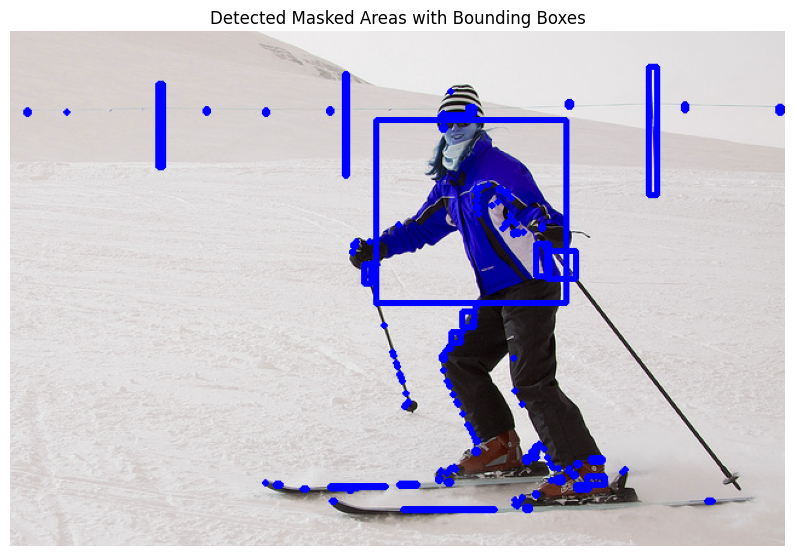

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image

# ‚úÖ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ‚úÖ Load the Model
#model = maskrcnn_resnet50_fpn(pretrained=False, num_classes=91).to(device)

# ‚úÖ Load the trained weights
model.load_state_dict(torch.load("mask_rcnn_trained.pth", map_location=device), strict=False)

# ‚úÖ Set model to evaluation mode
model.eval()
print("‚úÖ Model loaded successfully for testing!")

# ‚úÖ Enhanced Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2][::-1]  # (width, height)

    # ‚úÖ Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # ‚úÖ Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # ‚úÖ Apply Bilateral Filter (Preserves Edges)
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)

    # ‚úÖ Convert back to 3-channel image
    processed_image = cv2.cvtColor(filtered, cv2.COLOR_GRAY2RGB)

    # ‚úÖ Convert to PIL for Transformations
    pil_image = Image.fromarray(processed_image)

    # ‚úÖ Apply Torchvision Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale values
    ])
    image_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension

    return image_tensor.to(device), image, original_size

# ‚úÖ Function to Detect Masked Regions & Draw Bounding Boxes
def detect_masked_regions(image_np):
    # Convert to HSV for color-based segmentation
    hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

    # ‚úÖ Define a range for the masked color (e.g., blue tint in this case)
    lower_bound = np.array([90, 50, 50])   # Lower HSV range
    upper_bound = np.array([140, 255, 255])  # Upper HSV range

    # ‚úÖ Create a Mask
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # ‚úÖ Find Contours of Masked Areas
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ‚úÖ Draw Bounding Boxes
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue Box

    return image_np

# ‚úÖ Updated Visualization Function (Now with Bounding Boxes on Masked Areas)
def visualize_predictions(original_image, original_size, outputs, threshold=0.8):
    image_np = np.array(original_image)  # Convert PIL image to NumPy
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format

    # ‚úÖ Detect & Draw Bounding Boxes on Masked Regions
    image_np = detect_masked_regions(image_np)

    # ‚úÖ Display the Image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Masked Areas with Bounding Boxes")
    plt.show()

# ‚úÖ Specify Image Path
image_path = "val2017/000000000785.jpg"  # Change this to your test image

# ‚úÖ Load & Predict on the Selected Image
image_tensor, original_image, original_size = preprocess_image(image_path)

# ‚úÖ Run Inference
with torch.no_grad():
    outputs = model(image_tensor)[0]  # Get first image output

# ‚úÖ Visualize Results (Bounding Boxes Around Masked Regions)
visualize_predictions(original_image, original_size, outputs)
